##### Check the plot before VAE

In [1]:
import os
import json
import pandas as pd
import numpy as np
import torch
import random
import shutil
import rmm
import cupy as cp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from cuml.manifold.t_sne import TSNE 
from cuml.manifold import UMAP as cuUMAP

def numpy_to_tensor(data):
    data = torch.from_numpy(data).float()
    data = data.T
    return data
def perform_umap(data, n_neighbors=15, min_dist=0.1, n_components=2, save_dir=None):
    '''
    perform umap in GPU, cuML

    data : n_samples * n_features, numpy format

    Returns
    umap_space_cpu: n_samples * n_compontents, numpy format
    '''

    print("\n***Embedding with UMAP***")

    # Change the data type : numpy(cpu) into cupy(gpu)
    data = cp.asarray(data)

    # Run UMAP
    umap_model = cuUMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components)
    umap_space = umap_model.fit_transform(data)

    umap_save_dir = None
    if save_dir is not None:
        # Create 'umap' folder if not exists
        umap_save_dir = os.path.join(save_dir, 'umap')
        os.makedirs(umap_save_dir, exist_ok=True)

        # Save the result
        umap_result_path = os.path.join(umap_save_dir, f'umap_space_{n_neighbors}_{min_dist}.npy')
        np.save(umap_result_path, umap_space.get())
        print(f"Saved the UMAP result at {umap_result_path}.")

    # cuml(gpu) into numpy(cpu)
    umap_space_cpu = umap_space.get()

    # Free GPU memory by deleting GPU variables and clearing GPU memory cache
    del data, umap_space, umap_model
    cp.get_default_memory_pool().free_all_blocks()

    return umap_space_cpu, umap_save_dir  

In [2]:
amp_reshaped = np.load('/home/jiyoung/Desktop/lai_240524/Post-pose3D/result/newdebug/cwt/cwt_1_20_1_amp_reshaped_filter.npy')
preprocessed_data = numpy_to_tensor(amp_reshaped)
print(preprocessed_data.shape)

torch.Size([499650, 525])


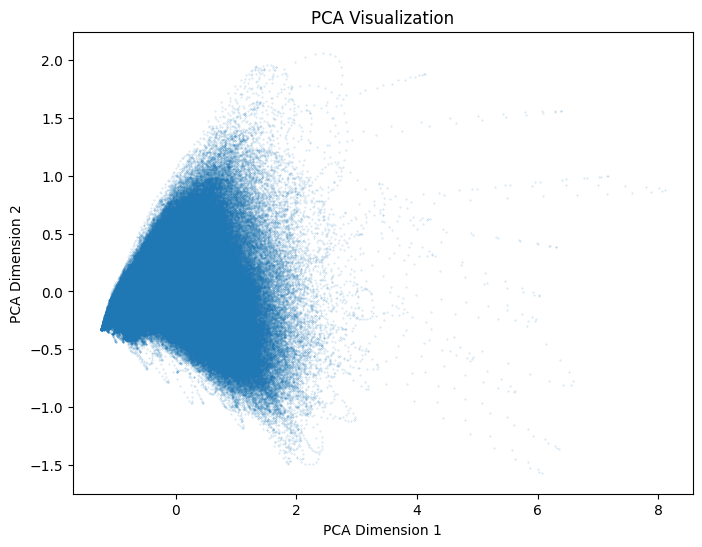

In [3]:
# Apply PCA
pca_embedding = PCA(n_components=2).fit_transform(preprocessed_data)

# Visualize the PCA results
plt.figure(figsize=(8, 6))
plt.scatter(pca_embedding[:, 0], pca_embedding[:, 1], s=0.1, alpha=0.3)
plt.title("PCA Visualization")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.show()

/home/jiyoung/anaconda3/envs/postpose/lib/python3.10/site-packages/cuml/internals/api_decorators.py:382: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return init_func(self, *args, **filtered_kwargs)


[W] [21:31:02.642294] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


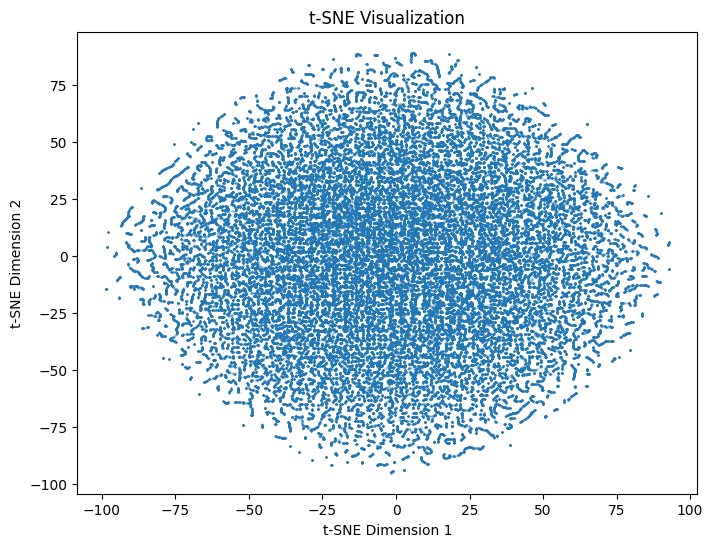

In [4]:
# Convert the torch tensor to a numpy array
preprocessed_data_numpy = preprocessed_data.numpy() 

tsne_embedding = TSNE(n_components=2, perplexity=50, n_neighbors=150).fit_transform(preprocessed_data_numpy)
# tsne_embedding: shape (n_samples, 2)
plt.figure(figsize=(8, 6))
plt.scatter(tsne_embedding[:, 0], tsne_embedding[:, 1], s=0.1, alpha=0.3)
plt.title("t-SNE Visualization")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()


***Embedding with UMAP***


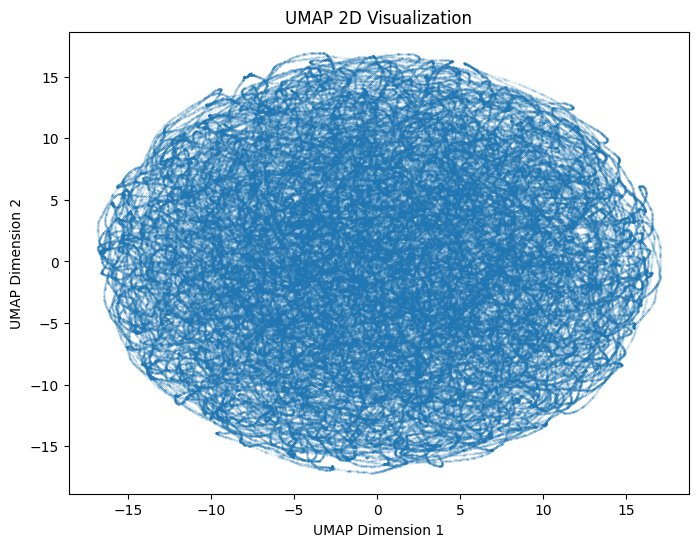

In [5]:
umap_embedding, _ = perform_umap(preprocessed_data)

plt.figure(figsize=(8, 6))
plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], s=0.1, alpha=0.3)
plt.title("UMAP 2D Visualization")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()

##### Check the plot in 2D space

In [21]:
latent_space = np.load('/home/jiyoung/Desktop/lai_240524/Post-pose3D/result/newdebug/deepvae/logs/20241201-022707/trial_17/vae_latentspace.npy')
print(latent_space.shape)

(499650, 54)


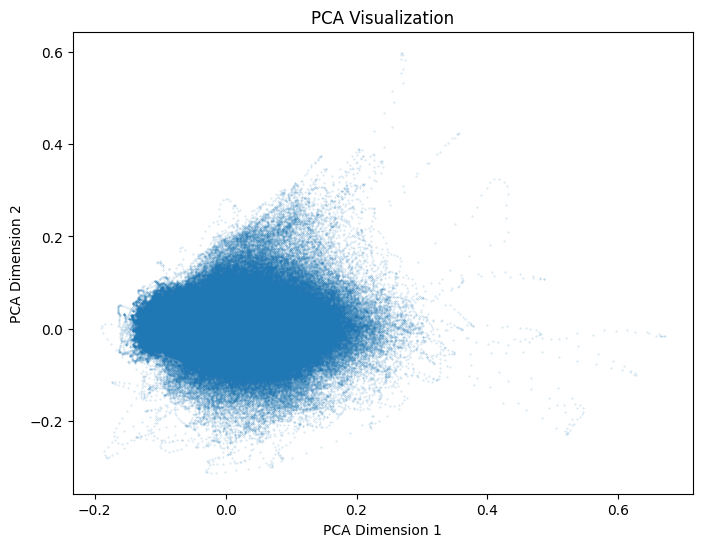

In [22]:
# Apply PCA
pca_embedding = PCA(n_components=2).fit_transform(latent_space)

# Visualize the PCA results
plt.figure(figsize=(8, 6))
plt.scatter(pca_embedding[:, 0], pca_embedding[:, 1], s=0.1, alpha=0.3)
plt.title("PCA Visualization")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.show()

/home/jiyoung/anaconda3/envs/postpose/lib/python3.10/site-packages/cuml/internals/api_decorators.py:382: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return init_func(self, *args, **filtered_kwargs)


[W] [21:39:04.266972] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


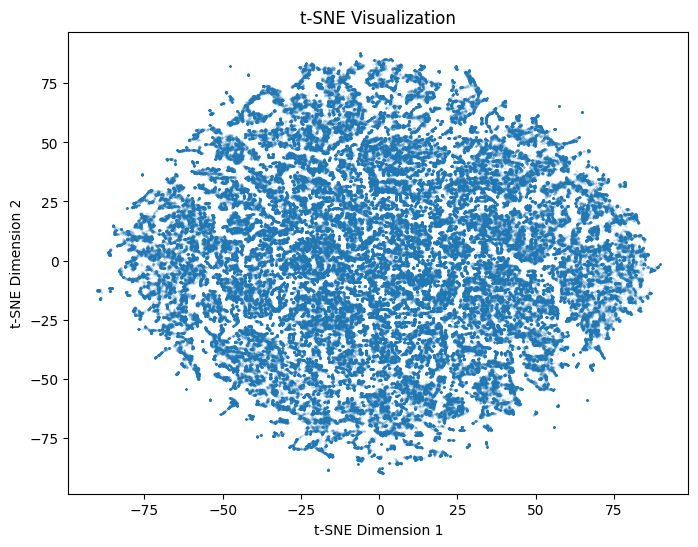

In [17]:
import matplotlib.pyplot as plt
from cuml.manifold.t_sne import TSNE 

tsne_embedding = TSNE(n_components=2, perplexity=50, n_neighbors=250).fit_transform(latent_space)
# tsne_embedding: shape (n_samples, 2)
plt.figure(figsize=(8, 6))
plt.scatter(tsne_embedding[:, 0], tsne_embedding[:, 1], s=0.1, alpha=0.3)
plt.title("t-SNE Visualization")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()


***Embedding with UMAP***


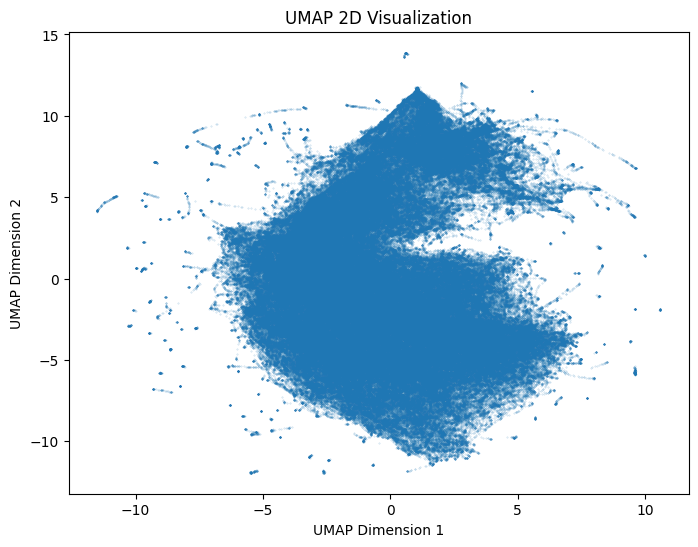

In [23]:
umap_embedding, _ = perform_umap(latent_space)

plt.figure(figsize=(8, 6))
plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], s=0.1, alpha=0.3)
plt.title("UMAP 2D Visualization")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()

##### Check the plot in 3D space

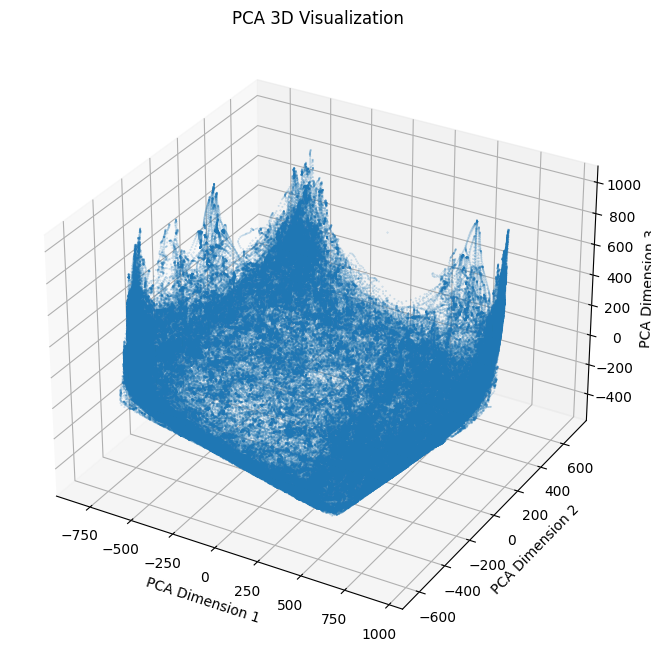

In [19]:
### PCA 3D ###
pca_embedding2 = PCA(n_components=3).fit_transform(latent_space)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_embedding2[:, 0], pca_embedding2[:, 1], pca_embedding2[:, 2], s=0.1, alpha=0.3)
ax.set_title("PCA 3D Visualization")
ax.set_xlabel("PCA Dimension 1")
ax.set_ylabel("PCA Dimension 2")
ax.set_zlabel("PCA Dimension 3")
plt.show()


***Embedding with UMAP***


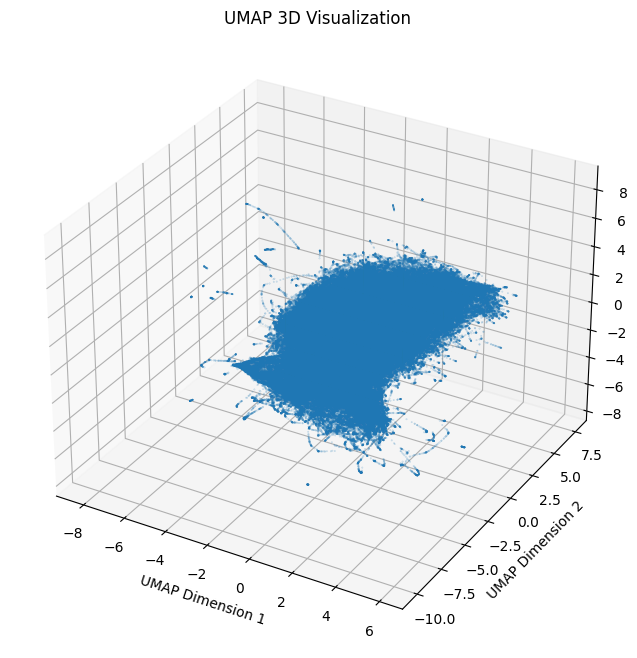

In [24]:
### UMAP 3D ###
umap_embedding2, _ = perform_umap(latent_space, n_components=3)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(umap_embedding2[:, 0], umap_embedding2[:, 1], umap_embedding2[:, 2], s=0.1, alpha=0.3)
ax.set_title("UMAP 3D Visualization")
ax.set_xlabel("UMAP Dimension 1")
ax.set_ylabel("UMAP Dimension 2")
ax.set_zlabel("UMAP Dimension 3")
plt.show()